# Overview

Our challenge is to build a machine learning model that accurately classifies whether a tweet is disaster related or not. The dataset contains 10,000 tweets. Our approach is to perform robust EDA to understand the data and identify strong class indicators that could drive model performance. We then apply a series of RNN based models, starting with a simple RNN and progressing through bidirectional and GRU architectures, to explore how different sequential structures affect learning and performance.

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
# Core Libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

# NLP Tools
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Model Training
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, SimpleRNN, GRU, Dense,
    Dropout, Bidirectional
)
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Evaluation Metrics
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score
)

# Keras-NLP
import keras_core as keras
import keras_nlp


2025-06-09 22:08:46.770884: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749506926.951627      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749506927.002200      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using TensorFlow backend


In [3]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [4]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


In [7]:
# Columns to check
missing_cols = ['keyword', 'location']

# Total number of rows in each set
total_train = len(df_train)
total_test  = len(df_test)

# Count of missing values in each column
count_train = df_train[missing_cols].isnull().sum()
count_test  = df_test[missing_cols].isnull().sum()

# Proportion of missing values
prop_train = count_train / total_train
prop_test  = count_test  / total_test

# Combine into a single DataFrame
proportions = pd.DataFrame({
    'train_missing_prop': prop_train,
    'test_missing_prop':  prop_test
})

print(proportions)

          train_missing_prop  test_missing_prop
keyword             0.008013           0.007968
location            0.332720           0.338645


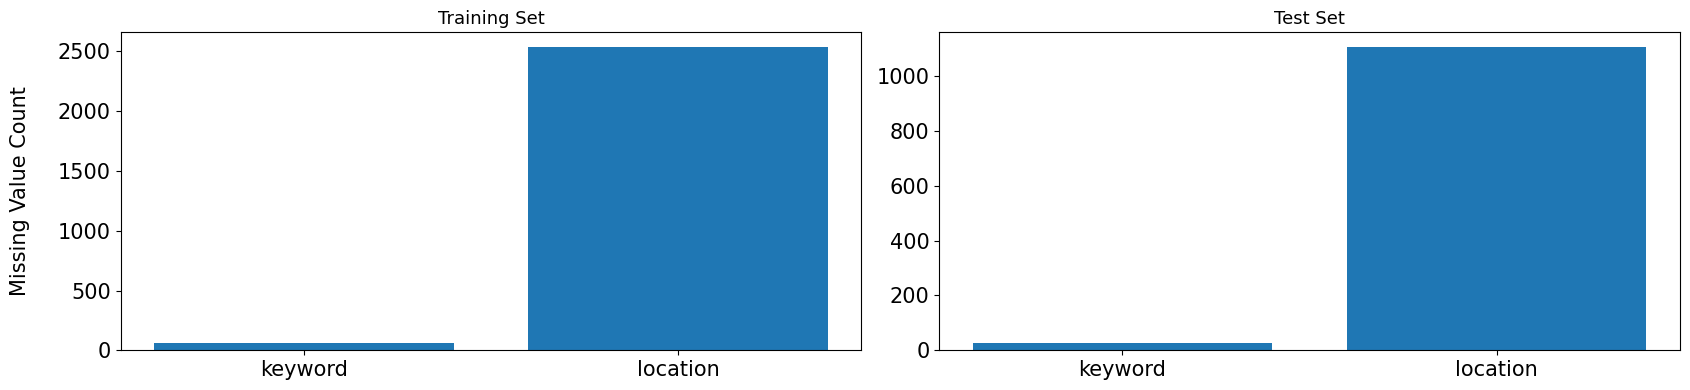

In [8]:
missing_cols = ['keyword', 'location']


missing_train = df_train[missing_cols].isnull().sum()
missing_test  = df_test[missing_cols].isnull().sum()


fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)


axes[0].bar(missing_train.index, missing_train.values)
axes[0].set_title('Training Set', fontsize=13)
axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)


axes[1].bar(missing_test.index, missing_test.values)
axes[1].set_title('Test Set', fontsize=13)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

plt.tight_layout()
plt.show()


for df in (df_train, df_test):
    for col in missing_cols:
        df[col] = df[col].fillna(f'no_{col}')

missing_cols = ['keyword', 'location']

The ratio of missing values for keyword and location is the same across the training and test sets.

.008% of keyword is missing in both sets
.33% of location is missing in both sets
The similar ratio indicates that our data was likely taken from the same sample. This data similarity should bolster model trainability.

# Surface Level Metrics

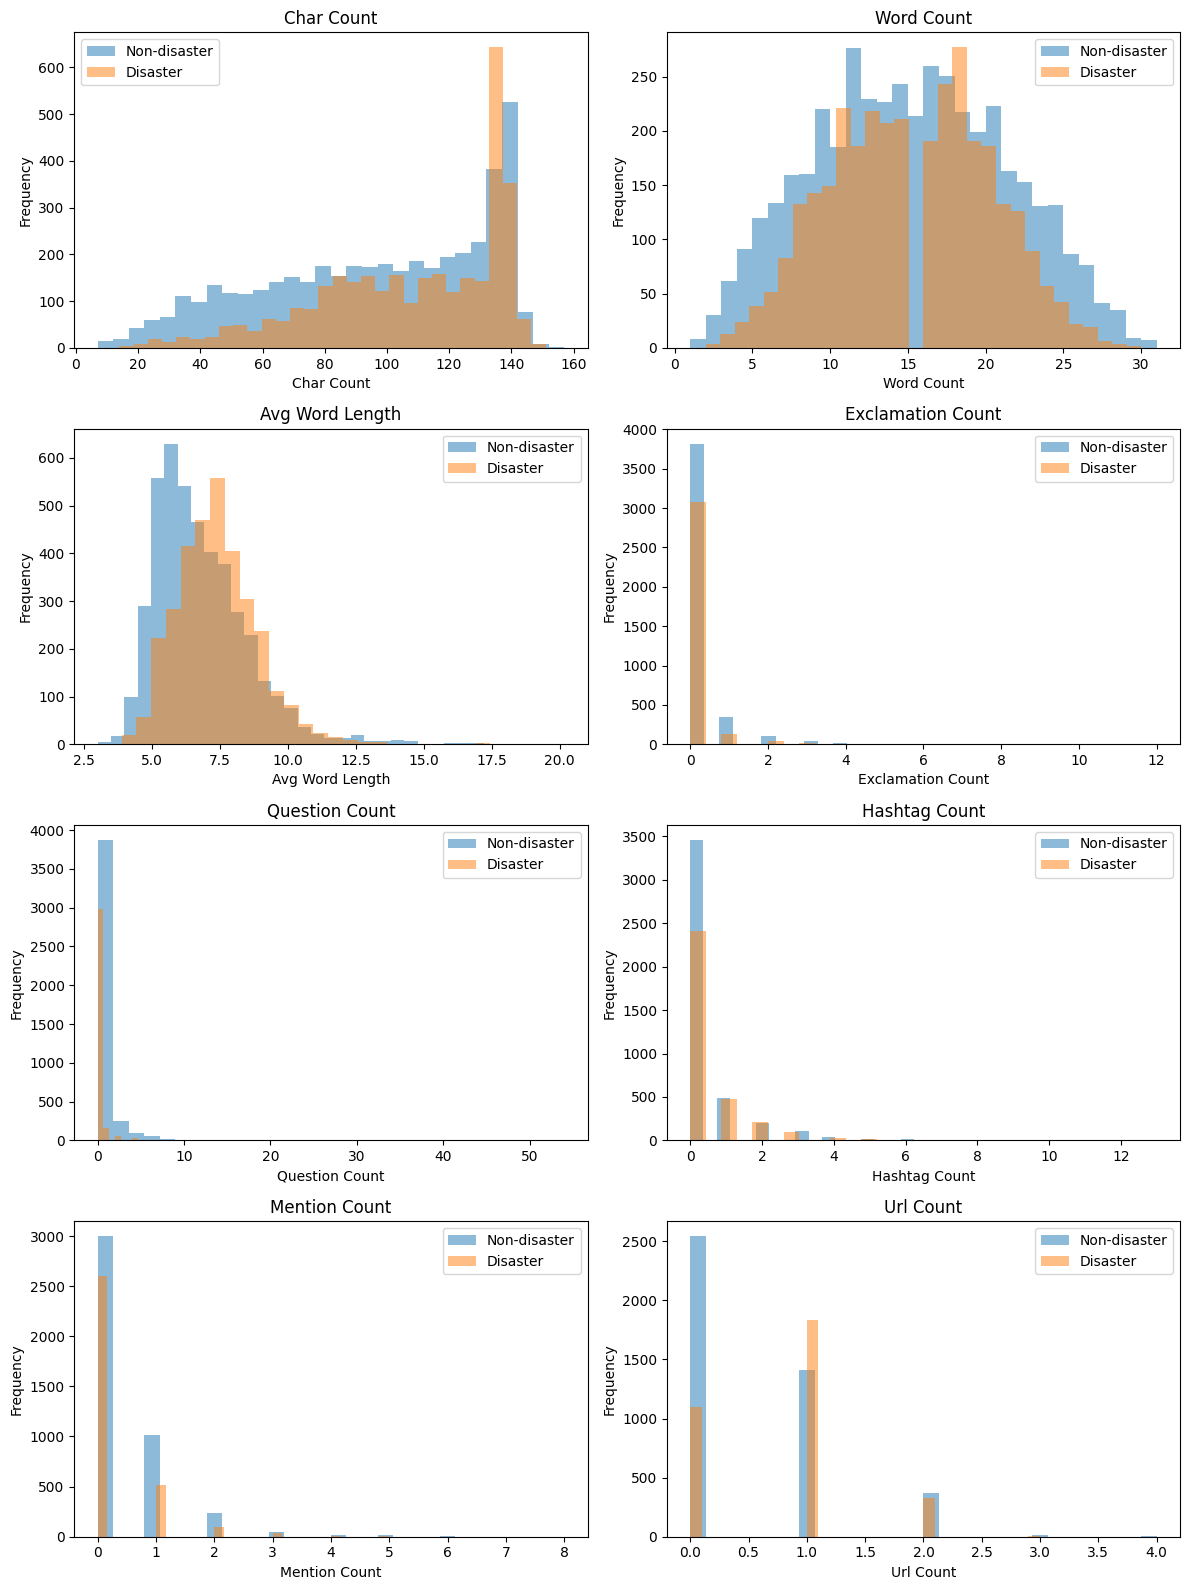

In [9]:
# Surface-metrics function
def compute_surface_metrics(df):
    metrics = pd.DataFrame(index=df.index)
    metrics['char_count']        = df['text'].str.len()
    metrics['word_count']        = df['text'].str.split().str.len()
    metrics['avg_word_length']   = np.where(
        metrics['word_count'] > 0,
        metrics['char_count'] / metrics['word_count'],
        0
    )
    metrics['exclamation_count'] = df['text'].str.count('!')
    metrics['question_count']    = df['text'].str.count(r'\?')
    metrics['hashtag_count']     = df['text'].str.count(r'#\w+')
    metrics['mention_count']     = df['text'].str.count(r'@\w+')
    metrics['url_count']         = df['text'].str.count(r'https?://\S+')
    return metrics

# Compute metrics
metrics_train = compute_surface_metrics(df_train)
metrics_train['target'] = df_train['target'].values

# Plot
metrics_to_plot = [
    'char_count', 'word_count', 'avg_word_length',
    'exclamation_count', 'question_count',
    'hashtag_count', 'mention_count', 'url_count'
]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 16))
axes = axes.flatten()

for ax, col in zip(axes, metrics_to_plot):
    ax.hist(
        metrics_train.loc[metrics_train['target'] == 0, col],
        bins=30, alpha=0.5, label='Non-disaster'
    )
    ax.hist(
        metrics_train.loc[metrics_train['target'] == 1, col],
        bins=30, alpha=0.5, label='Disaster'
    )
    ax.set_xlabel(col.replace('_', ' ').title())
    ax.set_ylabel('Frequency')
    ax.set_title(col.replace('_', ' ').title())
    ax.legend()

plt.tight_layout()
plt.show()

# Lexical Richness and Structure

In [10]:
# manually input stop words
stop_words = {
    "i","me","my","myself","we","our","ours","ourselves","you","your","yours",
    "yourself","yourselves","he","him","his","himself","she","her","hers",
    "herself","it","its","itself","they","them","their","theirs","themselves",
    "what","which","who","whom","this","that","these","those","am","is","are",
    "was","were","be","been","being","have","has","had","having","do","does",
    "did","doing","a","an","the","and","but","if","or","because","as","until",
    "while","of","at","by","for","with","about","against","between","into",
    "through","during","before","after","above","below","to","from","up","down",
    "in","out","on","off","over","under","again","further","then","once","here",
    "there","when","where","why","how","all","any","both","each","few","more",
    "most","other","some","such","no","nor","not","only","own","same","so",
    "than","too","very","s","t","can","will","just","don","should","now"
}

def compute_lexical_metrics(df):
    records = []
    for text in df['text'].astype(str):
        tokens = text.lower().split()
        total  = len(tokens)
        unique = len(set(tokens))
        ttr    = unique / total if total > 0 else 0
        sw_count = sum(1 for t in tokens if t in stop_words)
        sw_ratio = sw_count / total if total > 0 else 0
        
        records.append({
            'total_tokens':     total,
            'unique_tokens':    unique,
            'type_token_ratio': ttr,
            'stopword_ratio':   sw_ratio
        })
    
    metrics = pd.DataFrame.from_records(records, index=df.index)
    return metrics


lexical_train = compute_lexical_metrics(df_train)
lexical_train['target'] = df_train['target'].values

# group by class to assess output
grouped_means = lexical_train.groupby('target').mean().rename(index={0: 'Non-disaster', 1: 'Disaster'})
print(grouped_means)


              total_tokens  unique_tokens  type_token_ratio  stopword_ratio
target                                                                     
Non-disaster     14.704744      14.018194          0.964001        0.295237
Disaster         15.167533      14.548762          0.967118        0.249328


**Unexpected Lexical Patterns**

* Disaster-related tweets exhibit a marginally higher type–token ratio (0.967 vs. 0.964), contrary to our expectation of a narrower, crisis-specific vocabulary.
* The stopword ratio is lower in disaster tweets (0.249 vs. 0.295), indicating denser, more content-focused language.
* Our POS analysis also failed to show the anticipated uptick in nouns and action-oriented verbs in disaster tweets.

These findings suggest that, while disaster tweets may use more substantive language, they do not necessarily rely on a smaller set of crisis terms or more frequent action verbs.

# Preprocess the data

In [11]:
# Download stopwords 
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # remove URLs
    text = re.sub(r'&\w+;', '', text)  # remove HTML entities
    text = re.sub(r'@\w+', '', text)  # remove mentions
    text = re.sub(r'#', '', text)  # remove hashtag symbols but keep words
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = text.strip()  # trim whitespace

    # Tokenize and remove stopwords
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    
    return " ".join(tokens)

# Apply 
df_train['text_clean'] = df_train['text'].apply(clean_text)
df_test['text_clean'] = df_test['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# Before and after example
print("Original:")
print(df_train['text'].iloc[4])
print("\nCleaned:")
print(df_train['text_clean'].iloc[4])
# Fill missing keywords with a placeholder
df_train['keyword'].fillna('unknown', inplace=True)
df_test['keyword'].fillna('unknown', inplace=True)
df_train.drop(columns=['location'], inplace=True, errors='ignore')
df_test.drop(columns=['location'], inplace=True, errors='ignore')

Original:
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 

Cleaned:
got sent photo rubi alaska smoke wildfir pour school


/tmp/ipykernel_35/21793116.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['keyword'].fillna('unknown', inplace=True)
/tmp/ipykernel_35/21793116.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

In [14]:
df_train.drop(columns=['location'], inplace=True, errors='ignore')
df_test.drop(columns=['location'], inplace=True, errors='ignore')

After cleaning our data we re-examine our vocabulary metrics.

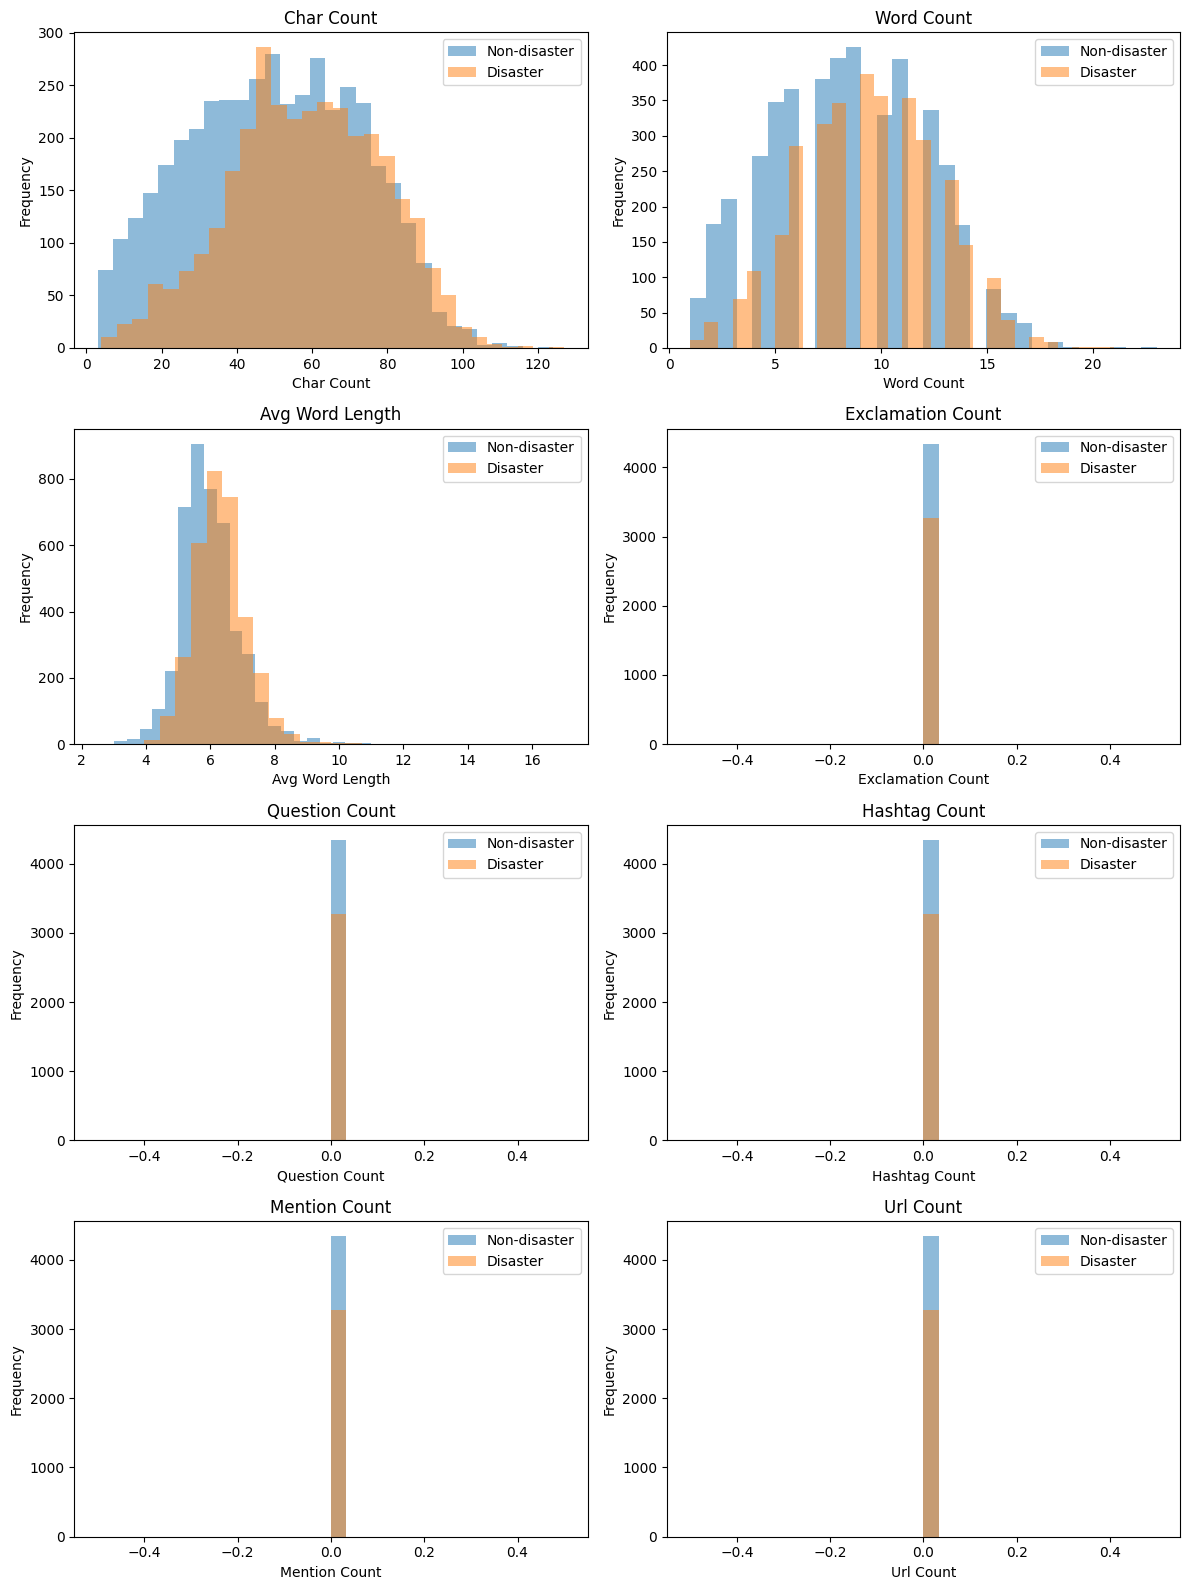

In [15]:
def compute_surface_metrics(df):
    metrics = pd.DataFrame(index=df.index)
    metrics['char_count']        = df['text_clean'].str.len()
    metrics['word_count']        = df['text_clean'].str.split().str.len()
    metrics['avg_word_length']   = np.where(
        metrics['word_count'] > 0,
        metrics['char_count'] / metrics['word_count'],
        0
    )
    metrics['exclamation_count'] = df['text_clean'].str.count('!')
    metrics['question_count']    = df['text_clean'].str.count(r'\?')
    metrics['hashtag_count']     = df['text_clean'].str.count(r'#\w+')
    metrics['mention_count']     = df['text_clean'].str.count(r'@\w+')
    metrics['url_count']         = df['text_clean'].str.count(r'https?://\S+')
    return metrics


metrics_train = compute_surface_metrics(df_train)
metrics_train['target'] = df_train['target'].values


metrics_to_plot = [
    'char_count', 'word_count', 'avg_word_length',
    'exclamation_count', 'question_count',
    'hashtag_count', 'mention_count', 'url_count'
]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 16))
axes = axes.flatten()

for ax, col in zip(axes, metrics_to_plot):
    ax.hist(
        metrics_train.loc[metrics_train['target'] == 0, col],
        bins=30, alpha=0.5, label='Non-disaster'
    )
    ax.hist(
        metrics_train.loc[metrics_train['target'] == 1, col],
        bins=30, alpha=0.5, label='Disaster'
    )
    ax.set_xlabel(col.replace('_', ' ').title())
    ax.set_ylabel('Frequency')
    ax.set_title(col.replace('_', ' ').title())
    ax.legend()

plt.tight_layout()
plt.show()

In [16]:
stop_words = {
    "i","me","my","myself","we","our","ours","ourselves","you","your","yours",
    "yourself","yourselves","he","him","his","himself","she","her","hers",
    "herself","it","its","itself","they","them","their","theirs","themselves",
    "what","which","who","whom","this","that","these","those","am","is","are",
    "was","were","be","been","being","have","has","had","having","do","does",
    "did","doing","a","an","the","and","but","if","or","because","as","until",
    "while","of","at","by","for","with","about","against","between","into",
    "through","during","before","after","above","below","to","from","up","down",
    "in","out","on","off","over","under","again","further","then","once","here",
    "there","when","where","why","how","all","any","both","each","few","more",
    "most","other","some","such","no","nor","not","only","own","same","so",
    "than","too","very","s","t","can","will","just","don","should","now"
}

def compute_lexical_metrics(df):
    records = []
    for text in df['text_clean'].astype(str):
        tokens = text.lower().split()
        total  = len(tokens)
        unique = len(set(tokens))
        ttr    = unique / total if total > 0 else 0
        sw_count = sum(1 for t in tokens if t in stop_words)
        sw_ratio = sw_count / total if total > 0 else 0
        
        records.append({
            'total_tokens':     total,
            'unique_tokens':    unique,
            'type_token_ratio': ttr,
            'stopword_ratio':   sw_ratio
        })
    
    metrics = pd.DataFrame.from_records(records, index=df.index)
    return metrics


lexical_train = compute_lexical_metrics(df_train)
lexical_train['target'] = df_train['target'].values


grouped_means = lexical_train.groupby('target').mean().rename(index={0: 'Non-disaster', 1: 'Disaster'})
print(grouped_means)


              total_tokens  unique_tokens  type_token_ratio  stopword_ratio
target                                                                     
Non-disaster      8.362275       8.140488          0.979498        0.006954
Disaster          9.285845       8.975237          0.973005        0.003004


After cleaning, both classes show increased lexical density. Non-disaster tweets have a slightly higher type–token ratio (0.979 vs. 0.973), suggesting more varied language. However, disaster tweets retain a higher token count, indicating more substantive content. The sharp drop in stopword ratios across both classes confirms effective text normalization.

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train["text_clean"])

X_train_seq = tokenizer.texts_to_sequences(df_train["text_clean"])
X_train_pad = pad_sequences(X_train_seq, maxlen=100, padding='post')


# Modeling

# Baseline RNN 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-06-09 22:11:53.684059: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



 Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,944,965 (7.42 MB)

 Trainable params: 648,321 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,296,644 (4.95 MB)

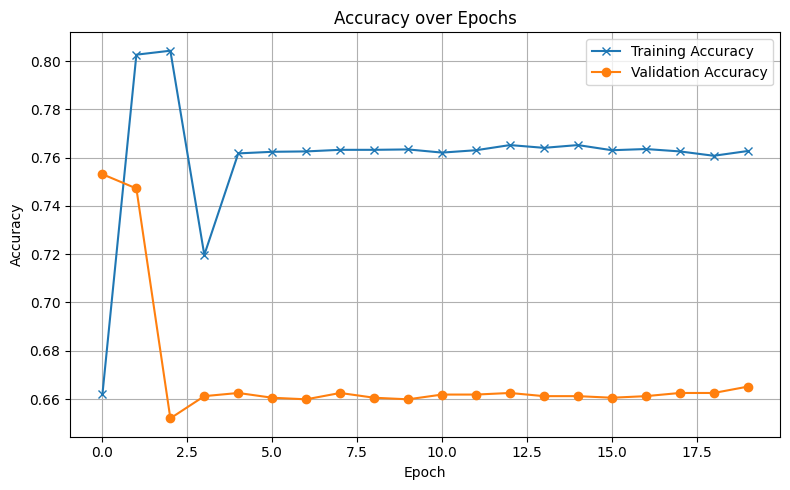

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


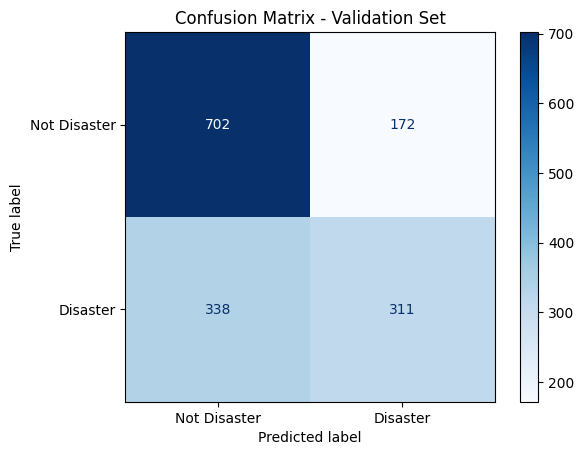


Final Validation Accuracy: 0.6651
Precision: 0.6439
Recall:    0.4792
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Sample predicted probabilities (P):
[0.3321 0.7472 0.1719 0.2922 0.2922 0.1719 0.2922 0.2922 0.2922 0.3321
 0.7472 0.2922 0.2922 0.2922 0.1719 0.2922 0.7472 0.2922 0.8166 0.3321]


In [18]:
# Parameters
VOCAB_SIZE = 10000
EMBED_DIM = 64
MAX_LEN = 100
BATCH_SIZE = 32
EPOCHS = 20

# Tokenization and Padding
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['text_clean'])

X = tokenizer.texts_to_sequences(df_train['text_clean'])
X = pad_sequences(X, maxlen=MAX_LEN, padding='post')

y = df_train['target'].values

X_train_pad, X_val_pad, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=MAX_LEN),
    SimpleRNN(64),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=0
)

# Summarize
print("\n Model Summary:")
model.summary()

# Plot Accuracy over epochs
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='x')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion Matrix 
y_val_pred = model.predict(X_val_pad)
y_val_pred_label = (y_val_pred >= 0.5).astype(int)

cm = confusion_matrix(y_val, y_val_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Disaster", "Disaster"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Validation Set")
plt.grid(False)
plt.show()

# Final Accuracy
final_val_acc = accuracy_score(y_val, y_val_pred_label)
print(f"\nFinal Validation Accuracy: {final_val_acc:.4f}")

# Precision and Recall
precision = precision_score(y_val, y_val_pred_label, zero_division=0)
recall = recall_score(y_val, y_val_pred_label, zero_division=0)
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

# Prediction
y_val_pred = model.predict(X_val_pad)

Our baseline model struggles with generalization, overfitting early and capturing only 48% of disaster tweets. Despite 64% precision, the recall deficit suggests the model misses too many actual disasters — an issue that inflates false negatives.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,969,925 (7.51 MB)

 Trainable params: 656,641 (2.50 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,313,284 (5.01 MB)

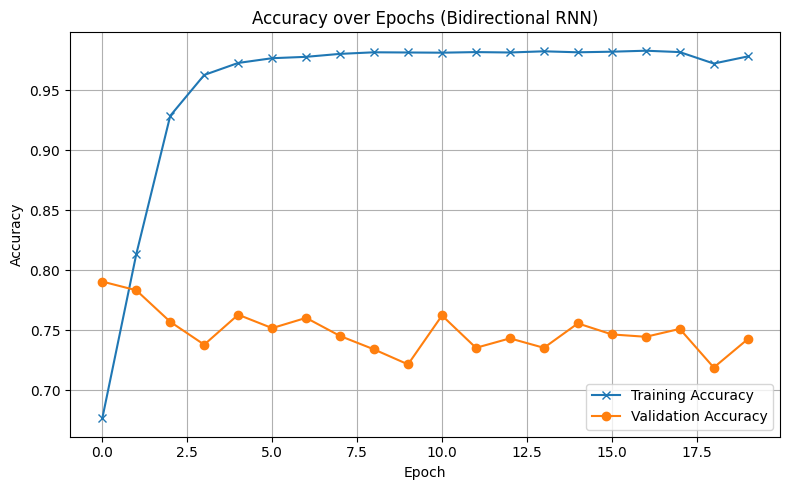

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


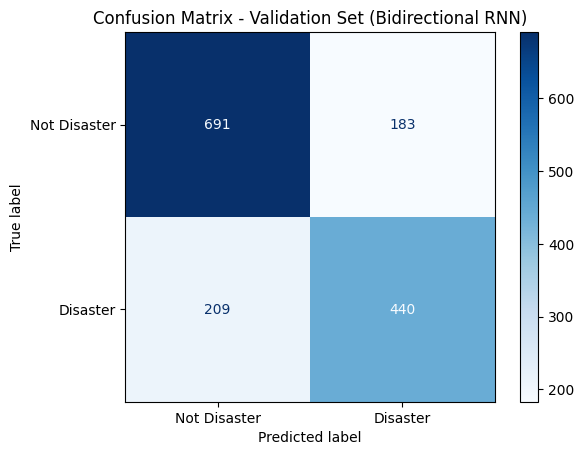


Final Validation Accuracy: 0.7426
Precision: 0.7063
Recall:    0.6780

Sample predicted probabilities (P):
[7.240e-02 5.600e-03 1.458e-01 6.000e-04 3.360e-02 3.080e-02 1.036e-01
 9.500e-03 8.400e-03 9.993e-01 1.641e-01 2.800e-02 6.300e-03 4.814e-01
 1.810e-02 1.320e-02 9.974e-01 2.517e-01 9.957e-01 1.400e-03]


In [19]:
VOCAB_SIZE = 10000
EMBED_DIM = 64
MAX_LEN = 100
BATCH_SIZE = 32
EPOCHS = 20


tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['text_clean'])

X = tokenizer.texts_to_sequences(df_train['text_clean'])
X = pad_sequences(X, maxlen=MAX_LEN, padding='post')

y = df_train['target'].values

X_train_pad, X_val_pad, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Bidirectional RNN Model
model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=MAX_LEN),
    Bidirectional(SimpleRNN(64)),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=0
)

# Summary
print("\nModel Summary:")
model.summary()

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='x')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy over Epochs (Bidirectional RNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion Matrix
y_val_pred = model.predict(X_val_pad)
y_val_pred_label = (y_val_pred >= 0.5).astype(int)

cm = confusion_matrix(y_val, y_val_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Disaster", "Disaster"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Validation Set (Bidirectional RNN)")
plt.grid(False)
plt.show()

# Final Accuracy 
final_val_acc = accuracy_score(y_val, y_val_pred_label)
print(f"\nFinal Validation Accuracy: {final_val_acc:.4f}")

# Precision and Recall
precision = precision_score(y_val, y_val_pred_label, zero_division=0)
recall = recall_score(y_val, y_val_pred_label, zero_division=0)
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

Introducing bidirectionality helps the model converge faster by leveraging both past and future context. Still, the model hits a ceiling, with validation accuracy plateauing just below 75%. This indicates improved pattern recognition but continued overfitting and similar training dynamics to our baseline.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.

Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 100, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,969,925 (7.51 MB)

 Trainable params: 656,641 (2.50 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,313,284 (5.01 MB)

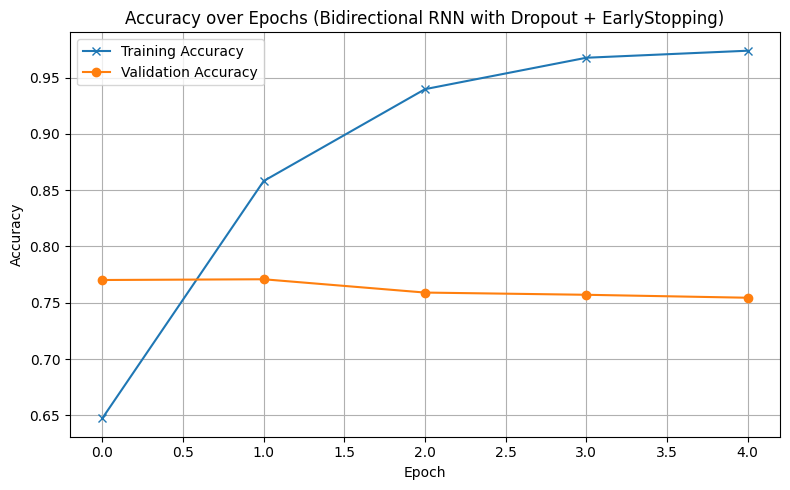

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


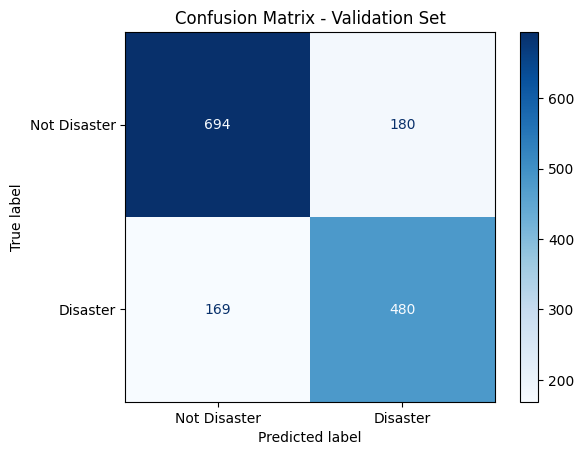


Final Validation Accuracy: 0.7708
Precision: 0.7273
Recall:    0.7396

Sample predicted probabilities (P):
[0.1722 0.1086 0.4236 0.0775 0.3575 0.5412 0.2667 0.1142 0.0727 0.884
 0.6652 0.1639 0.1698 0.3263 0.1093 0.3057 0.959  0.1076 0.9465 0.0546]


In [20]:
VOCAB_SIZE = 10000
EMBED_DIM = 64
MAX_LEN = 100
BATCH_SIZE = 32
EPOCHS = 20

# Tokenization and Padding
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['text_clean'])

X = tokenizer.texts_to_sequences(df_train['text_clean'])
X = pad_sequences(X, maxlen=MAX_LEN, padding='post')

y = df_train['target'].values

X_train_pad, X_val_pad, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Model with Dropout
model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=MAX_LEN),
    Bidirectional(SimpleRNN(64)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Train
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=0
)

# Summary
print("\nModel Summary:")
model.summary()

# Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='x')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy over Epochs (Bidirectional RNN with Dropout + EarlyStopping)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Predictions & Evaluation
y_val_pred = model.predict(X_val_pad)
y_val_pred_label = (y_val_pred >= 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Disaster", "Disaster"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Validation Set")
plt.grid(False)
plt.show()

# Final Accuracy
final_val_acc = accuracy_score(y_val, y_val_pred_label)
print(f"\nFinal Validation Accuracy: {final_val_acc:.4f}")

# Precision & Recall
precision = precision_score(y_val, y_val_pred_label, zero_division=0)
recall = recall_score(y_val, y_val_pred_label, zero_division=0)
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

Dropout slightly reduces overfitting, and early stopping prevents redundant epochs. We see modest gains and validation metrics plateau in the low to mid 70s. Precision and recall improve, but false positives and false negatives remain too high for deployment-grade reliability.

# Bidirectional GRU Model 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.

Model Summary:


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ (None, 100, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 128)                 │          49,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,070,149 (7.90 MB)

 Trainable params: 690,049 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,380,100 (5.26 MB)

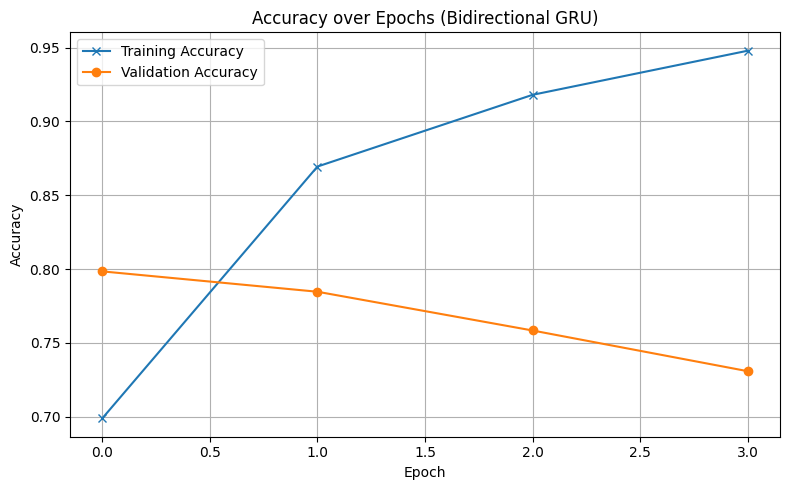

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


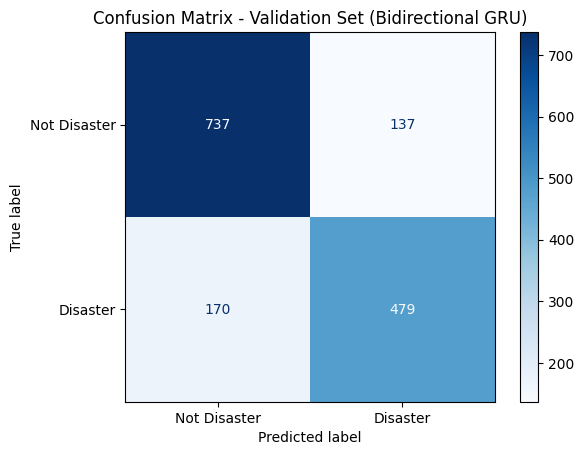


Final Validation Accuracy: 0.7984
Precision: 0.7776
Recall:    0.7381
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Saved submission.csv


In [27]:
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

# Tokenization and Padding
VOCAB_SIZE = 10000
EMBED_DIM = 64
MAX_LEN = 100
BATCH_SIZE = 32
EPOCHS = 20

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['text_clean'])

X = tokenizer.texts_to_sequences(df_train['text_clean'])
X = pad_sequences(X, maxlen=MAX_LEN, padding='post')
y = df_train['target'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#Class Weights
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))

# Bidirectional GRU Model
model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=MAX_LEN),
    Bidirectional(GRU(64)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#  Train with Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=0
)

# Summary
print("\nModel Summary:")
model.summary()

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='x')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy over Epochs (Bidirectional GRU)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Predictions
y_val_pred = model.predict(X_val).ravel()
y_val_pred_label = (y_val_pred >= 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Disaster", "Disaster"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Validation Set (Bidirectional GRU)")
plt.grid(False)
plt.show()

# Metrics
final_val_acc = accuracy_score(y_val, y_val_pred_label)
precision = precision_score(y_val, y_val_pred_label, zero_division=0)
recall = recall_score(y_val, y_val_pred_label, zero_division=0)

print(f"\nFinal Validation Accuracy: {final_val_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

# Test Set Preparation
X_test = tokenizer.texts_to_sequences(df_test['text_clean'])
X_test = pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

# Test Predictions and Submission
y_test_pred = model.predict(X_test).ravel()
y_test_pred_label = (y_test_pred >= 0.5).astype(int)

submission['target'] = y_test_pred_label
submission.to_csv("submission.csv", index=False)
print("Saved submission.csv")

The GRU architecture delivers a marked performance jump, capturing 74% of disaster tweets with 78% precision. This indicates better handling of long term dependencies and more selective attention to relevant context. The confusion matrix reflects this shift as false negatives drop and true positives rise significantly, demonstrating that the GRU’s gating mechanism meaningfully improves both recall and precision.

# Conclusion

Our model progression highlights that architectural enhancements alone aren't enough; regularization and memory mechanisms are critical. While bidirectionality improves context, the GRU’s gating delivers the biggest impact by reducing false negatives and boosting precision. Ultimately, the bidirectional GRU strikes the best balance between contextual understanding and generalization, making it the strongest candidate for reliable disaster tweet classification.